In [319]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import earthpy as et 
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
import folium
from scipy import stats
import sklearn
from sklearn.preprocessing import StandardScaler

In [320]:
#importation bdd nettoyées

mode_acces = pd.read_excel('mode_acces.xlsx')
motif_dep = pd.read_excel('motif_dep.xlsx')
distance_parcourue = pd.read_excel('distance_parcourue.xlsx')
freq_gare = pd.read_excel('freq_gare.xlsx')
intermodalite = pd.read_excel('intermodalite.xlsx')
wifi = pd.read_excel('wifi.xlsx')
travaux = pd.read_excel('travaux.xlsx')
temps_prec = pd.read_excel('temps_prec.xlsx')
type_clients = pd.read_excel('type_clients.xlsx')
csp_voyageurs = pd.read_excel('csp_voyageurs.xlsx')
age_voyageurs = pd.read_excel('age_voyageurs.xlsx')
genre_voyageurs = pd.read_excel('genre_voyageurs.xlsx')
referentiel_gare = pd.read_excel('referentiel_gare.xlsx')

satisfaction = pd.read_excel('clean_satisfaction.xlsx')
satis_gare = pd.read_excel('clean_satisfaction_uniq_gare.xlsx')

In [321]:
# CRÉATION DF MERGE GARES X LOCALISATION

#chaque gare est identifiée par son code UIC (clé SNCF)

In [322]:
satis_gare = satis_gare.rename(columns={'Code UIC': 'uic_code'})

In [323]:
referentiel_gare['uic_code'] = referentiel_gare['uic_code'].apply(lambda s: s-87000000)

In [324]:
#suppression valeurs manquantes satisfaction 2017

satis_gare = satis_gare[satis_gare['sept 2017']!='-']

In [325]:
#satis_loc : merge satisfaction (2017) x localisation de la gare
#colonnes: code UIC (clé de la gare), Gare, satisfaction 2017, UG gare, coordonnées longitude/latitude wgs84 (2 colonnes)
#ATTENTION: slt 156 gares dans satif_loc --> gares enquétées sur la satisfaction. On suppose qu'il s'agit d'un échantillon représentatif des gares françaises

satis_loc = satis_gare[['uic_code', 'Gare', 'sept 2017', 'UG']].set_index('uic_code').merge(referentiel_gare[['uic_code', 'wgs_84.lon', 'wgs_84.lat']].set_index('uic_code'), on='uic_code')

In [326]:
satis_loc = satis_loc.rename(columns={'sept 2017': 'satisfaction-2017'})

In [327]:
satis_loc=satis_loc.reset_index()
#on enlève les index dans un 1er temps pour que les colonnes soient des listes et non des pandas series

In [328]:
# CREATION CARTE FRANCAISES GARES

#layering: fond de carte (découpage france métropolitaine par départements) + position des gares enquétées

In [329]:
#importation de la base donnée contenant le découpage de la france métropolitaine selon les départements
#format shapefile

departement = gpd.read_file("departements-20180101.shp", crs="EPSG:4326")

#importation de la base de donnée contenant le découpage de paris par intramuros
#Pour zoom sur Paris pour question de visibilité
arrondissements = gpd.read_file("https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
arrondissements = arrondissements.rename(columns = {"c_arinsee": "insee"})
arrondissements['insee'] = arrondissements['insee'].astype(str)

In [330]:
#filtrage: on garde seulement les départements de France métropolitaine

l=[]
for i in range (departement.shape[0]):
    l.append(len(departement['code_insee'][i])<3)
    
departement = departement[l]   

In [331]:
#on convertit les coordonnées wgs84 (sous forme xy) en format Point (shapefile), compatible avec les geometries geopandas

wgs84_points = []
for i in range (satis_loc.shape[0]):
    wgs84_points.append(Point([satis_loc['wgs_84.lon'][i], satis_loc['wgs_84.lat'][i]]))

satis_loc['geometry'] = wgs84_points

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [332]:
#conversion du dataframe en GeoDataFrame

loc_gares_gpd = gpd.GeoDataFrame(satis_loc, crs="EPSG:4326")

<AxesSubplot:>

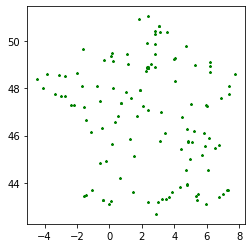

In [333]:
loc_gares_gpd.plot(marker='*', color='green', markersize=5)

<AxesSubplot:>

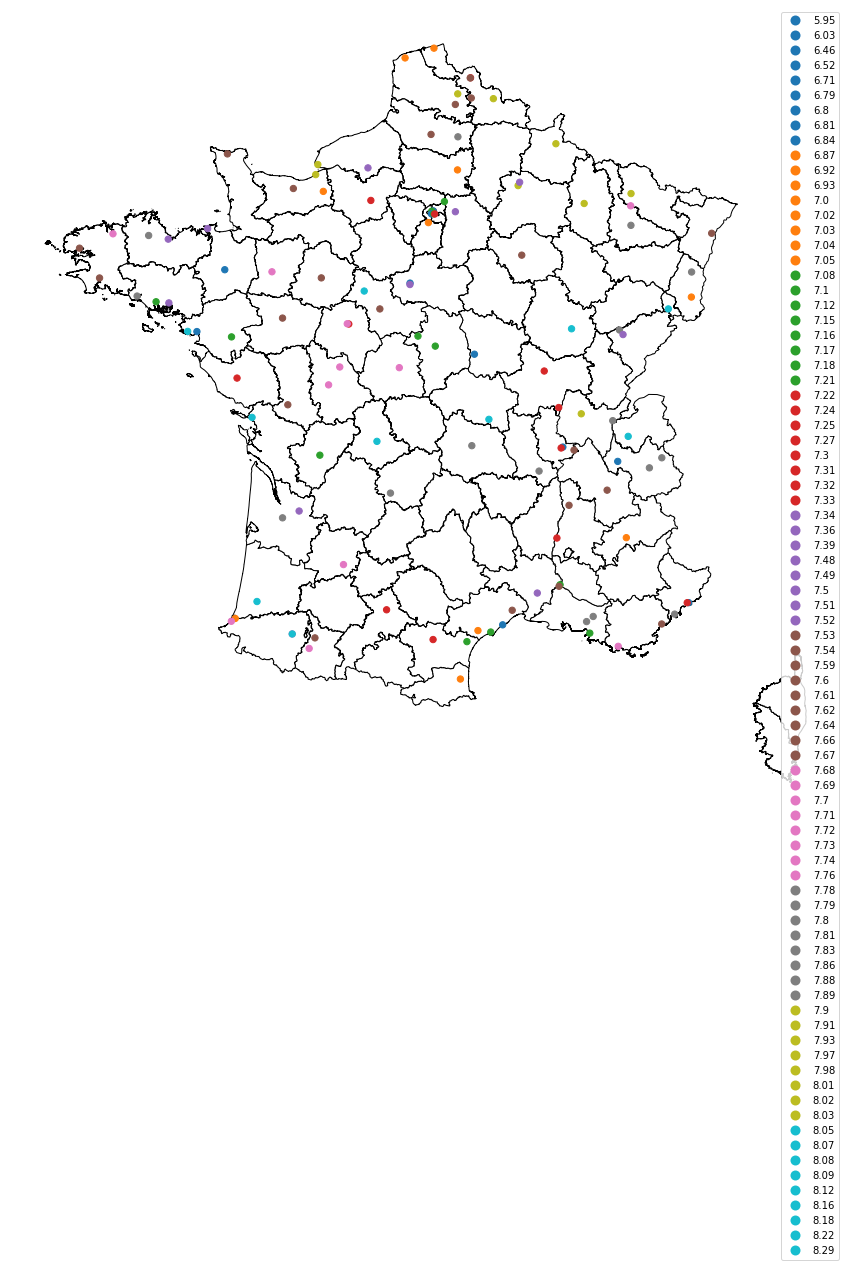

In [334]:
fig,ax = plt.subplots(figsize=(15, 15))
departement.plot(ax = ax, color='white', edgecolor='black')

loc_gares_gpd.plot(ax=ax, marker='o', markersize=40, column='satisfaction-2017', legend=True)
ax.set_axis_off()
ax

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


<AxesSubplot:>

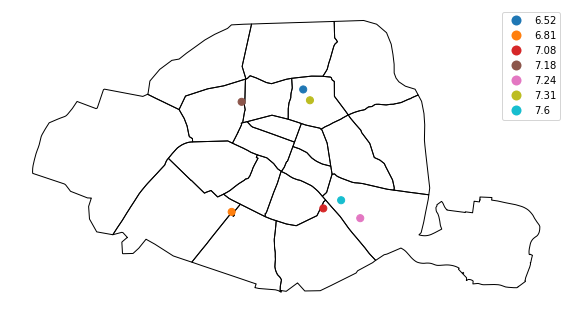

In [335]:
fig,ax = plt.subplots(figsize=(10, 10))

arrondissements.plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none", color = None)
loc_gares_gpd[loc_gares_gpd['UG'].isin(['Paris Sud', 'Paris Nord'])][loc_gares_gpd['wgs_84.lon']<2.5][loc_gares_gpd['wgs_84.lat']>48.8].plot(ax=ax, marker='o', markersize=50, column='satisfaction-2017', legend=True)
ax.set_axis_off()
ax

In [336]:
# AUTRE CARTE: interactive 

In [92]:
#pour la carte interactive:

from pathlib import Path
Path("leaflet").mkdir(parents=True, exist_ok=True)

In [93]:
#pour le dégradé de couleur (de bleu clair à bleu foncé, pour le niveau de satisfaction dans chaque gare)

import seaborn as sns
pal = sns.color_palette("Blues", n_colors=satis_loc.shape[0])

In [94]:
#bdd triée dans l'ordre croissant

satis_loc = satis_loc.sort_values(['satisfaction-2017'], ascending=True)

In [95]:
# attribution d'une couleur à chaque gare: de bleu clair (pour les moins stisfaisantes) à bleus foncés (pour les + satisfaisantes)

satis_loc["color"]=pal.as_hex()

In [96]:
# création de la carte interactive :
#  - dégradé de couleur selon le niveau de stisfaction (de bleu clair (pour les moins stisfaisantes) à bleus foncés (pour les + satisfaisantes))
#  - taille du cerle de la gare fonction (croissante) du niveau de satisfaction
#  - 



center = satis_loc[['wgs_84.lat', 'wgs_84.lon']].mean().values.tolist()
sw = satis_loc[['wgs_84.lat', 'wgs_84.lon']].min().values.tolist()
ne = satis_loc[['wgs_84.lat', 'wgs_84.lon']].max().values.tolist()



m = folium.Map(location = center, tiles='Stamen Toner')

for i in range(0,len(satis_loc)):
   folium.Circle(
      location=[satis_loc.iloc[i]['wgs_84.lat'], satis_loc.iloc[i]['wgs_84.lon']],
      popup= str(satis_loc.iloc[i]['Gare']) + ": <br> " + str(satis_loc.iloc[i]['satisfaction-2017']),
      radius=np.exp(satis_loc.iloc[i]['satisfaction-2017']+2),
      color='black',
      weight = 1,
      fill=True,
      fill_color=satis_loc.iloc[i]['color'],
      fill_opacity=0.9
   ).add_to(m)
m.fit_bounds([sw, ne])
m

In [97]:
## CORRELATION

In [98]:
distance_parcourue_wide = distance_parcourue.rename(columns={'uic': 'uic_code'}).pivot_table(index='uic_code', columns='classe_distance_gare_gare', values='pourcentage')
motif_dep_wide = motif_dep.rename(columns={'uic': 'uic_code'}).pivot_table(index='uic_code', columns='motif_du_deplacement', values='pourcentage')
freq_gare_wide = freq_gare.rename(columns={'uic': 'uic_code'}).pivot_table(index='uic_code', columns='frequence', values='pourcentage')
type_clients_wide = type_clients.rename(columns={'uic': 'uic_code'}).pivot_table(index='uic_code', columns='type_d_usager', values='pourcentage')
age_voyageurs_wide = age_voyageurs.rename(columns={'uic': 'uic_code'}).pivot_table(index='uic_code', columns='classe_d_age', values='pourcentage')
genre_voyageurs_wide = genre_voyageurs.rename(columns={'uic': 'uic_code'}).pivot_table(index='uic_code', columns='sexe', values='pourcentage')

#faire une base travaux avec le niveau de travaux indiqués dans la base satisfaction

In [99]:
#grande table mergée: pour chaque gare: niveau satisfactino + répartition selon:
#                                                                                - distance parcourue
#                                                                                - motif de déplacement 
#                                                                                - fréquence de venue dans la gare
#                                                                                - type de clients
#                                                                                - tranche d'âge voyageurs
#                                                                                - genre voyageurs

satis_merge_all = satis_gare[['uic_code', 'Gare', 'sept 2017', 'UG']].set_index('uic_code').merge(distance_parcourue_wide, on='uic_code').merge(motif_dep_wide, on='uic_code').merge(freq_gare_wide, on='uic_code').merge(type_clients_wide, on='uic_code').merge(age_voyageurs_wide, on='uic_code').merge(genre_voyageurs_wide, on='uic_code')

In [100]:
# variable mean_year moyenne d'âge estimée des voyageurs

satis_merge_all = satis_merge_all.assign(mean_age=lambda x: (satis_merge_all['19 ans et moins']*15 + satis_merge_all['20 ans à 29 ans']*25 +  satis_merge_all['30 ans à 39 ans']*35 + satis_merge_all['40 ans à 49 ans']*45 + satis_merge_all['50 ans à 59 ans']*55 + satis_merge_all['60 ans et plus']*65)/100)


In [162]:
# A LIRE: test régression linéaire c la cata MAIS c'est pas grave, c'est intéressant de savoir que les variables sur les indivs sont décorrélées de la satisfaction et que cette dernière ne dépend donc pas des caractéristiques des voyageurs mais bien de celles de la gare

# a faire: fonction pour faire tourner ce bout de code sur d'autres variables


x = np.array(satis_merge_all.dropna(subset=['Déplacement domicile - travail habituel'])['sept 2017'].tolist())
y = np.array(satis_merge_all.dropna(subset=['Déplacement domicile - travail habituel'])['Déplacement domicile - travail habituel'].tolist())

lr = scipy.stats.linregress(x, y)
lr

res = stats.linregress(x, y)

print(f"R-squared: {res.rvalue**2:.6f}")

plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

LinregressResult(slope=-5.198115221013172, intercept=70.88203255677752, rvalue=-0.17492292478474925, pvalue=0.28683497403527647, stderr=4.810057394843458, intercept_stderr=36.219968860742206)

In [ ]:
# test clustering

In [196]:
# k-means clustering -- peut être interessant; au moins on a le bout de code
from numpy import unique
from numpy import where
from sklearn.cluster import KMeans
from matplotlib import pyplot
# define dataset
X = satis_merge_all[['Démarches administratives, médicales ou achat', 'Déplacement domicile - travail habituel', 'Déplacement domicile - étude (y compris stage)', 'Déplacement professionnel occasionnel', "Loisirs, vacances, visite d'un proche ou ami"]].dropna()
# define the model
model = KMeans(n_clusters=6)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)


In [ ]:
#### TEST 2: ACP SUR LES VARIABLES DE SATISFACTION:
#   -  les informations
#   -  les déplacements
#   -  la propreté et la sûreté
#   -  la qualité du moment passé en gare
#   -  les commerces et les services
#   -  l’architecture et les animations
#   -  la mobilité durable

In [301]:
# on regare des variables pour mars 2021 (première date à partir de laquelle on a des données pour les variables de satisfaction)

satis_2021 = satisfaction[['Gare', 'Code UIC', 'mars 2021', 
                           'mars 2021.2', 'mars 2021.3',
                          'mars 2021.4', 'mars 2021.6', 'mars 2021.7',
                          'mars 2021.8', 'mars 2021.9']]

# 1 ligne = 1 gare
satis_2021 = satis_2021[-satis_2021['Code UIC'].isnull()]
del satis_2021['Code UIC']

satis_2021 = satis_2021.set_index(['Gare'], drop=True)


satis_2021.columns = ['satisfaction globale', 'informations', 
                     'déplacements', 'propreté et sûreté', 'qualité moment en gare',
                     'commerces et les services', 'architecture et les animations',
                     ' mobilité durable']

In [302]:
for i in satis_2021.columns[2:10]:
    satis_2021 = satis_2021[satis_2021[i]!='-']

In [303]:
from sklearn.preprocessing import StandardScaler
#instanciation
sc = StandardScaler()
#transformation – centrage-réduction
Z = sc.fit_transform(satis_2021)

In [268]:
Z_df = pd.DataFrame(Z, index = satis_2021['Gare'], columns = satis_2021.columns[1:])

In [279]:
#ACP
from sklearn.decomposition import PCA

#instanciation
acp = PCA(svd_solver='full')

coord = acp.fit_transform(Z_df)
#nombre de composantes calculées 
print(acp.n_components_) #8

# valeurs singulières matrice variance/covariance (= sqrt(valeurs propres) car matrice de variance covariance symétrique positive)
# directions propres 
n, p = Z_df.shape[0], Z_df.shape[1]
eigval = (n-1)/n*acp.explained_variance_
print(eigval)

#proportion de variance expliquée par chaque axe
print(acp.explained_variance_ratio_)
# les 2 premiers axes expliquent 76% de la variance du nuage du point --> on prend ces 2 premiers axes pour représenter les gares dans le plan

8
[4.53816711 1.53723068 0.69647884 0.49298576 0.25849419 0.20605573
 0.1663849  0.1042028 ]
[0.56727089 0.19215383 0.08705985 0.06162322 0.03231177 0.02575697
 0.02079811 0.01302535]


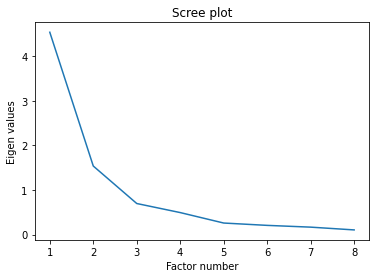

In [282]:
#scree plot
plt.plot(np.arange(1,p+1),eigval) 
plt.title("Scree plot") 
plt.ylabel("Eigen values") 
plt.xlabel("Factor number") 
plt.show()

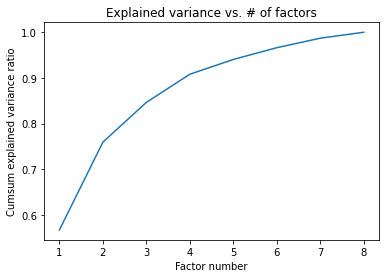

In [286]:
#cumul de variance expliquée
plt.plot(np.arange(1,p+1),np.cumsum(acp.explained_variance_ratio_)) 
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
plt.show()

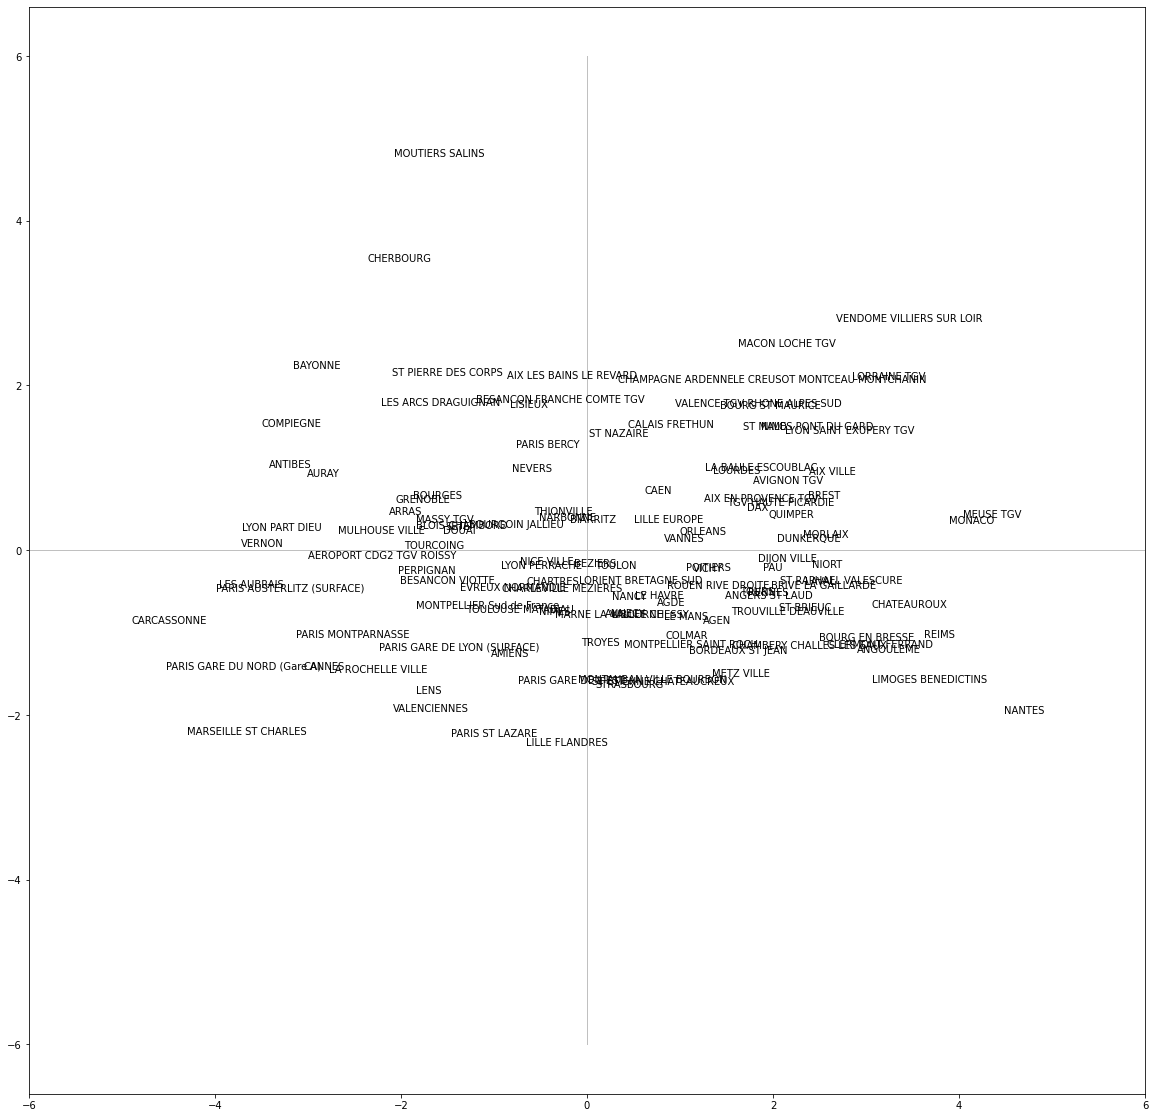

In [318]:
#positionnement des individus dans le premier plan
fig, axes = plt.subplots(figsize=(20,20)) 
axes.set_xlim(-6,6) #même limites en abscisse axes.set_ylim(-6,6) #et en ordonnée
#placement des étiquettes des observations
for i in range(n):
    plt.annotate(satis_2021.index[i],(coord[i,0],coord[i,1]))
#ajouter les axes
plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1) 
plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)
#affichage
plt.show()

In [309]:
#corrélation des variables avec les axes
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]
#afficher la matrice des corrélations variables x facteurs

In [311]:
# analyse des corrélations axes/variables

print(pd.DataFrame({'id':satis_2021.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))

                               id     COR_1     COR_2
0            satisfaction globale  0.888723 -0.015936
1                    informations  0.797372  0.399882
2                    déplacements  0.787450  0.322477
3              propreté et sûreté  0.770130  0.453531
4          qualité moment en gare  0.888124  0.086959
5       commerces et les services  0.484405 -0.610721
6  architecture et les animations  0.538785 -0.734727
7                mobilité durable  0.765283 -0.383436


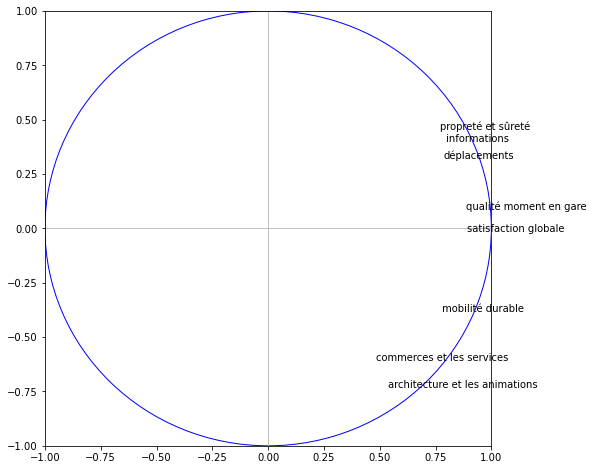

In [314]:
#cercle des corrélations
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)

#affichage des étiquettes (noms des variables)
for j in range(p): plt.annotate(satis_2021.columns[j],(corvar[j,0],corvar[j,1]))

#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1) 
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False) 
axes.add_artist(cercle)

#affichage
plt.show()

In [317]:
#contributions
cos2var = corvar**2
ctrvar = cos2var
for k in range(p):
    ctrvar[:,k] = ctrvar[:,k]/eigval[k]
#on n'affiche que pour les deux premiers axes
print(pd.DataFrame({'id':satis_2021.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1]}))

                               id     CTR_1     CTR_2
0            satisfaction globale  0.174041  0.000165
1                    informations  0.140101  0.104022
2                    déplacements  0.136636  0.067648
3              propreté et sûreté  0.130691  0.133806
4          qualité moment en gare  0.173807  0.004919
5       commerces et les services  0.051705  0.242631
6  architecture et les animations  0.063966  0.351166
7                mobilité durable  0.129052  0.095642
